<a href="https://colab.research.google.com/github/SIVASKANDAN-P/GESTURE_RECOGNITION/blob/main/Neural_Nets_Project_Starter_bharath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [70]:
# Running on GPU

import platform
import tensorflow as tf

print("Python version: ", platform.python_version())
print("TensorFlow version: ", tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU not found. Running on CPU.')
else:
    print('GPU found. Running on GPU.')

Python version:  3.10.12
TensorFlow version:  2.12.0
GPU not found. Running on CPU.


In [71]:
!pip install imageio

In [73]:
import numpy as np
import os
# from scipy.misc import imread, imresize
from skimage.transform import resize
from imageio import imread
import imageio
import datetime
import os
import warnings
warnings.filterwarnings('ignore')


We set the random seed so that the results don't vary drastically.

In [74]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
# tf.set_random_seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [75]:
#train_doc = np.random.permutation(open('/content/drive/My Drive/Project_data/train.csv').readlines())
#val_doc = np.random.permutation(open('/content/drive/My Drive/Project_data/val.csv').readlines())
train_doc = np.random.permutation(open('/content/drive/MyDrive/gesture recognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/gesture recognition/Project_data/val.csv').readlines())
batch_size = 10 # experiment with the batch size

In [76]:
# np.random.seed(5)
# random_numbers = np.random.randint(0, 30, size=18)
# random_numbers

In [77]:
# samples_per_folder = 18

# def batchsize(folder_list):
#   result = math.ceil(folder_list.length *  samples_per_folder / batch_size)
#   print('result is =', result)

In [78]:
# batch_size = 10 # experiment with the batch size
# selecting alternate frames
# seq_idx =  np.round(np.linspace(0, 29, 20)).astype(int)
# image dimensions
# dim_x, dim_y = 120, 120

In [79]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 120, 120, 3]

# define image tensor size
img_tensor = getImgTensor(20)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 120, 120, 3]


In [80]:
def cropResize(image, y, z):
    h, w = image.shape

    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return resize(image, (y,z))

In [81]:
def normalizeImage(image):
    # applying normalization
    return image/255.0

In [82]:
def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))

In [83]:
def genhelper(source_path, folder_list, batch_size, img_tensor, t, batch):
  [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
  # img_idx = [1,4,5,6,7,9,21]
  # print('IMG tensor ...', img_tensor[0])
  img_idx = img_tensor[0]
  # print('IMG DX list', img_idx)
  batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
  batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
  for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                # print(' Foder currently reading : ='+ source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                # print('IMGS...', imgs)

                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    # print('image index count : = ', idx , ' ; item =', item)
                    # print('Batch: = ', batch , ' ; Batch size: =', batch_size , ' ; index =' , batch*batch_size)
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z) #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
  return batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [84]:
def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # print('folder list length = ', folder_list)
    # [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    # img_idx = img_tensor[0]

    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size) # calculate the number of batches
        print('; Num of batches =', num_batches)
        for batch in range(num_batches): # we iterate over the number of batches
            # print('; Current Batch =', batch)
            yield genhelper(source_path, folder_list, batch_size, img_tensor, t, batch)#you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        if len(folder_list)%batch_size != 0:
          batch_size = len(folder_list)%batch_size
          yield genhelper(source_path, folder_list, batch_size, img_tensor, t, batch)#you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [85]:
curr_dt_time = datetime.datetime.now()
#train_path = '/content/drive/My Drive/Project_data/train'
#val_path = '/content/drive/My Drive/Project_data/val'
train_path = '/content/drive/MyDrive/gesture recognition/Project_data/train'
val_path = '/content/drive/MyDrive/gesture recognition/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


Testing if the generator code is working properly.

In [86]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, 32, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

Source path =  /content/drive/MyDrive/gesture recognition/Project_data/train ; batch size = 32
; Num of batches = 20
(32, 20, 120, 120, 3)


In [87]:
# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  /content/drive/MyDrive/gesture recognition/Project_data/val ; batch size = 10
; Num of batches = 10
(10, 20, 120, 120, 3)


It is working as expected.

In [88]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

print(make2dFilter(5))

(5, 5)


In [89]:
 inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])
 print(inputShape)

(20, 120, 120, 3)


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [90]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

# #write your model here

# # Create a Sequential model
# model = Sequential()

# # Add Conv3D layer
# model.add(Conv3D(filters=16, kernel_size=(5, 5, 5), activation='relu', input_shape=(inputShape)))

# # Add Conv3D layer
# model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu'))

# # Add Conv3D layer
# model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu'))

# # Add MaxPooling3D layer
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# # Add Flatten layer
# model.add(Flatten())

# # Add Dense layers
# model.add(Dense(128, activation='relu'))
# model.add(Dense(64, activation='softmax'))  # num_classes is the number of classes in your problem

# Compile the model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [22]:
# optimiser = 'adam'
# model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print (model.summary())

In [23]:
def defineModel(img_tensor):
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

model = defineModel(img_tensor)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 116, 116, 16)  6016      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 58, 58, 16)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 8, 58, 58, 16)    64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 56, 56, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 28, 28, 32)    0         
 3D)                                                             
                                                        

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

/content/model_init_2023-09-0403_45_48.436660

In [91]:
#defining train generator
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
#defining val generator
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

In [92]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [93]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [94]:
# setting epochs to 10.
num_epochs = 10

In [32]:
import matplotlib.pyplot as plt

Defining plotting function to plot model accuracy and loss in both train and test.

In [95]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
# @title Base model running
base_model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/gesture recognition/Project_data/train ; batch size = 10
; Num of batches = 66
Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.6303 - categorical_accuracy: 0.4148 Source path =  /content/drive/MyDrive/gesture recognition/Project_data/val ; batch size = 10
; Num of batches = 10
; Num of batches = 10

Epoch 1: saving model to model_init_2023-09-0211_37_06.054011/model-00001-1.63031-0.41478-8.61776-0.24000.h5
67/67 [==============================] - 2748s 42s/step - loss: 1.6303 - categorical_accuracy: 0.4148 - val_loss: 8.6178 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.9246 - categorical_accuracy: 0.2587; Num of batches = 10

Epoch 2: saving model to model_init_2023-09-0211_37_06.054011/model-00002-1.92455-0.25871-7.76273-0.23000.h5
67/67 [==============================] - 158s 2s/step - loss: 1.9246 - categorical_accuracy: 0.2587 - val_loss: 7.7627 - val

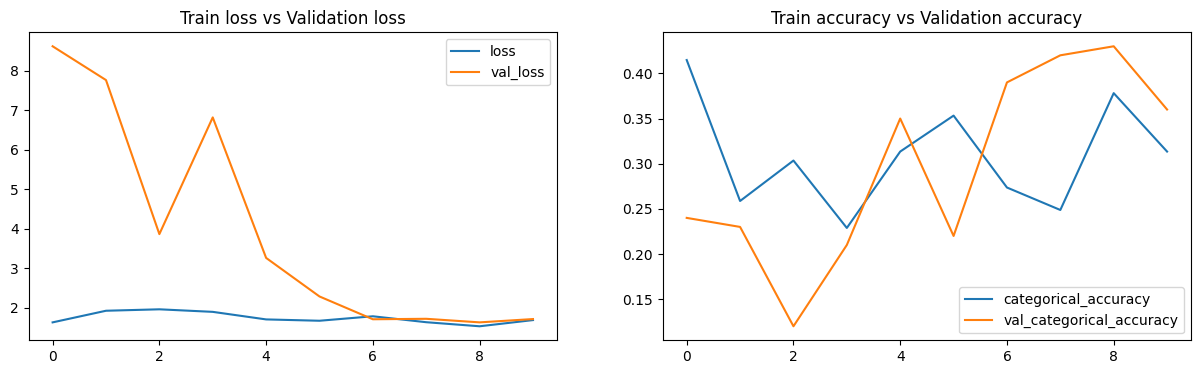

Max. Training Accuracy 0.4147813022136688
Max. Validaiton Accuracy 0.4300000071525574


In [ ]:
plotModelHistory(base_model_history)

### Testing Batch size and frames

In [ ]:
def batchsizetester(n_frames, batch_size):
  # n_frames = 16
  num_epochs = 3
  # batch_size = 64

  img_tensor = getImgTensor(n_frames)
  print("Using frames as", img_tensor[0])
  train_generator = generator(train_path, train_doc, batch_size, img_tensor)
  val_generator = generator(val_path, val_doc, batch_size, img_tensor)

  if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
  else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
  else:
    validation_steps = (num_val_sequences//batch_size) + 1

  model = defineModel(img_tensor)

  model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

  plotModelHistory(model_history)

Using frames as [ 0  1  3  4  6  7  8 10 11 12 14 15 17 18 19 21 22 23 25 26 28 29]
Source path =  /content/drive/MyDrive/gesture recognition/Project_data/train ; batch size = 64
; Num of batches = 10
Epoch 1/3
11/11 [==============================] - ETA: 0s - loss: 1.4163 - categorical_accuracy: 0.5023  Source path =  /content/drive/MyDrive/gesture recognition/Project_data/val ; batch size = 64
; Num of batches = 1
; Num of batches = 2

Epoch 1: saving model to model_init_2023-09-0211_37_06.054011/model-00001-1.41633-0.50226-8.63691-0.20000.h5
11/11 [==============================] - 1121s 107s/step - loss: 1.4163 - categorical_accuracy: 0.5023 - val_loss: 8.6369 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/3
11/11 [==============================] - ETA: 0s - loss: 0.8958 - categorical_accuracy: 0.6443 ; Num of batches = 3

Epoch 2: saving model to model_init_2023-09-0211_37_06.054011/model-00002-0.89578-0.64427-8.10334-0.23438.h5
11/11 [==============================] - 2

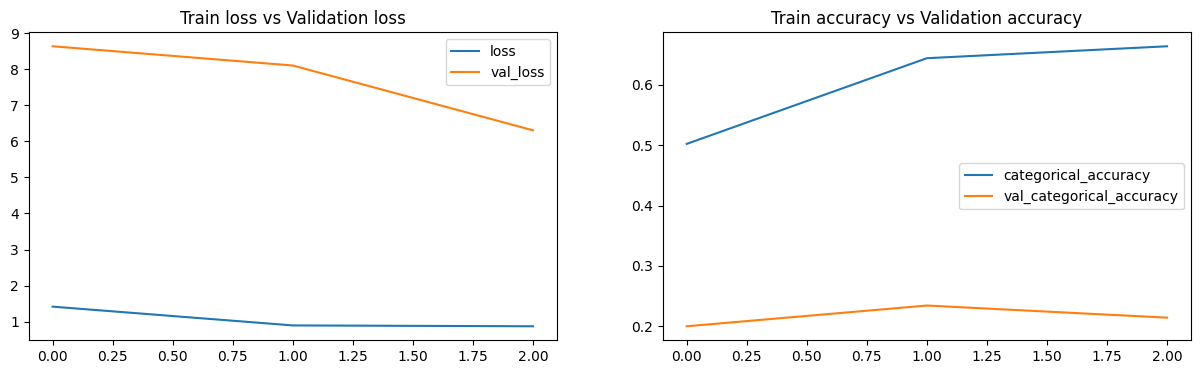

Max. Training Accuracy 0.6640316247940063
Max. Validaiton Accuracy 0.234375


In [ ]:
batchsizetester(22, 64)

Using frames as [ 0  2  4  6  8 10 12 15 17 19 21 23 25 27 29]
Source path =  /content/drive/MyDrive/gesture recognition/Project_data/train ; batch size = 32
; Num of batches = 20
Epoch 1/3
21/21 [==============================] - ETA: 0s - loss: 1.4209 - categorical_accuracy: 0.4555 Source path =  /content/drive/MyDrive/gesture recognition/Project_data/val ; batch size = 32
; Num of batches = 3
; Num of batches = 25

Epoch 1: saving model to model_init_2023-09-0211_37_06.054011/model-00001-1.42085-0.45551-2.58824-0.20000.h5
21/21 [==============================] - 305s 15s/step - loss: 1.4209 - categorical_accuracy: 0.4555 - val_loss: 2.5882 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/3
21/21 [==============================] - ETA: 0s - loss: 0.9537 - categorical_accuracy: 0.6335 
Epoch 2: saving model to model_init_2023-09-0211_37_06.054011/model-00002-0.95372-0.63354-3.00796-0.25000.h5
21/21 [==============================] - 216s 10s/step - loss: 0.9537 - categorical_ac

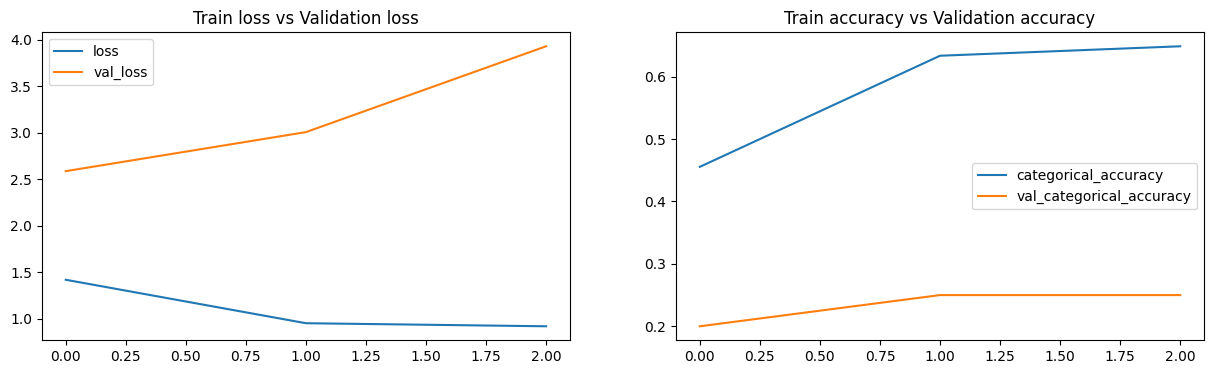

Max. Training Accuracy 0.6487119197845459
Max. Validaiton Accuracy 0.25


In [ ]:
batchsizetester(15, 32)

### Batch size is not helping much hence we will try out other options

### Experiment 1

Model 1 - Frames-16, Epoc-25

In [ ]:
n_frames = 16
num_epochs = 15
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])


In [ ]:
model1 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.50),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.50),

    Dense(5, activation='softmax')
], name="conv_3d1")

In [ ]:
model1.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model1.summary())

Model: "conv_3d1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 12, 116, 116, 16)  6016      
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 6, 58, 58, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_15 (Bat  (None, 6, 58, 58, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_10 (Conv3D)          (None, 4, 56, 56, 32)     13856     
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 4, 28, 28, 32)    0         
 g3D)                                                            
                                                          

In [ ]:
model1_history = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/gesture recognition/Project_data/train ; batch size = 64
; Num of batches = 10
Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 1.9483 - categorical_accuracy: 0.3544 Source path =  /content/drive/MyDrive/gesture recognition/Project_data/val ; batch size = 64
; Num of batches = 1
; Num of batches = 2

Epoch 1: saving model to model_init_2023-09-0211_37_06.054011/model-00001-1.94830-0.35445-11.07328-0.21000.h5
11/11 [==============================] - 326s 29s/step - loss: 1.9483 - categorical_accuracy: 0.3544 - val_loss: 11.0733 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.2957 - categorical_accuracy: 0.5573 ; Num of batches = 3

Epoch 2: saving model to model_init_2023-09-0211_37_06.054011/model-00002-1.29570-0.55731-14.77685-0.21875.h5
11/11 [==============================] - 128s 12s/step - loss: 1.2957 - categorical_accuracy: 0.5573 - val_loss: 14.7768 - v

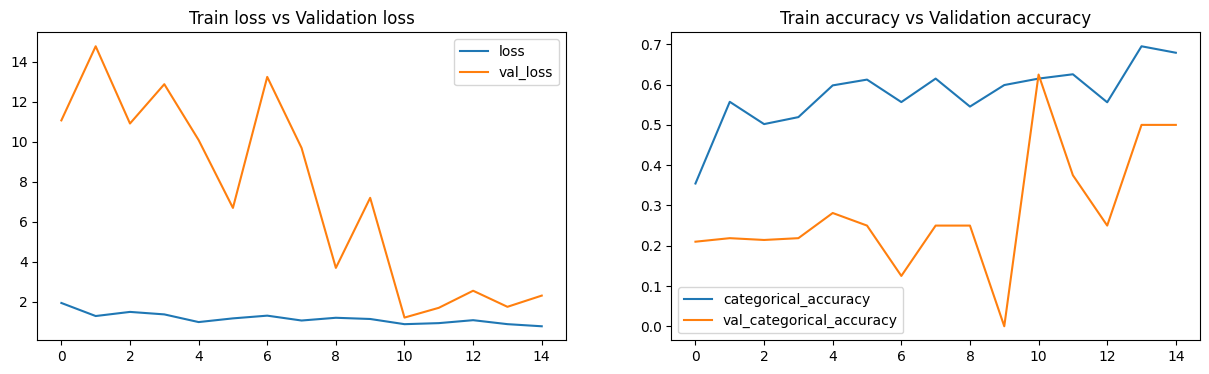

Max. Training Accuracy 0.6951871514320374
Max. Validaiton Accuracy 0.625


In [ ]:
plotModelHistory(model1_history)

In [29]:
# @title Experiment 2

n_frames = 30
num_epochs = 30
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

print(inputShape)


(30, 120, 120, 3)


In [31]:
model2 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    # Dropout(0.25),

    # Conv3D(64, make3dFilter(3), activation='relu'),
    # MaxPooling3D(pool_size=(1,2,2), padding='same'),
    # BatchNormalization(),
    # # Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.50),


    # Conv3D(64, make3dFilter(5), activation='relu'),
    # MaxPooling3D(pool_size=(1,2,2), padding='same'),
    # BatchNormalization(),


    Dense(5, activation='softmax')
], name="conv_3d2")



In [ ]:
model2.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model2.summary())

model2_history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(model2_history)

Model: "conv_3d2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 16, 116, 116, 16)  6016      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 8, 58, 58, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 8, 58, 58, 16)    64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 6, 56, 56, 32)     13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 6, 28, 28, 32)    0         
 3D)                                                             
                                                          

In [ ]:
# @title Experiment 3 - less parameters

n_frames = 30
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])


In [ ]:
model3 = Sequential([
    Conv3D(16, make3dFilter(3), padding='same', activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d3")

In [ ]:
model3.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model3.summary())

model3_history = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(model3_history)

In [28]:
# @title Experiment 5
n_frames = 20
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

In [ ]:
model4 = Sequential([
    Conv3D(16, make3dFilter(3), padding='same', activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(128, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d4")

In [ ]:
model4.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model4.summary())

model4_history = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(model4_history)

In [ ]:
# @title Experiment 6: Conv2D+LSTM
n_frames = 20
num_epochs = 30
batch_size = 32

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model6 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")

In [ ]:
model6.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6.summary())

model6_history = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(model6_history)

In [22]:
import resnet

img_channels = 3
img_rows = 120
img_cols = 120

nb_classes = 5

ModuleNotFoundError: ignored

In [ ]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)

model7.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model7_history = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(model6_history)

In [38]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import LSTM, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape

# Step 1: Load pre-trained ResNet-50
#base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(120, 120, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(120, 120, 3))
# Step 2: Freeze the ResNet layers (optional, depending on your task)
for layer in base_model.layers:
    layer.trainable = False

# Step 3: Define your RNN layer (LSTM in this case)
input_size = 2048  # This should match the output feature size of ResNet-50
hidden_size = 512
num_layers = 1
rnn = LSTM(hidden_size, return_sequences=False, return_state=False)

# Step 4: Build the custom model
input_tensor = Input(shape=(120, 120, 3))
x = base_model(input_tensor)
x = Flatten()(x)  # Flatten the output
x = Reshape((1, -1))(x)
x = rnn(x)
output_layer = Dense(5, activation='softmax')  # Adjust num_classes for your task
output = output_layer(x)

# Step 5: Create the model
model7 = Model(inputs=input_tensor, outputs=output)


# Step 6: Compile the model (customize loss and optimizer for your task)
model7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model7.summary()



58889256/58889256 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 120, 120, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 4608)              0         
                                                                 
 reshape_3 (Reshape)         (None, 1, 4608)           0         
                                                                 
 lstm_5 (LSTM)               (None, 512)               10487808  
                                                                 
 dense_2 (Dense)             (None, 5)                 2565      
                                                            

In [53]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Input
from tensorflow.keras.models import Model

# Define VGGNet for feature extraction
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(120, 120, 3))
for layer in base_model.layers:
    layer.trainable = False

# Define LSTM layer
input_sequence = Input(shape=(20, 120, 120, 3))
feature_sequence = TimeDistributed(base_model)(input_sequence)
flattened_features = TimeDistributed(Flatten())(feature_sequence)
lstm_output = LSTM(512)(flattened_features)  # Adjust parameters as needed

# Add output layer for your specific task (e.g., classification)
output = Dense(5, activation='softmax')(lstm_output)

# Create the model
model7 = Model(inputs=input_sequence, outputs=output)

In [102]:
def genhelper(source_path, folder_list, batch_size, img_tensor, t, batch):
  [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
  # img_idx = [1,4,5,6,7,9,21]
  # print('IMG tensor ...', img_tensor[0])
  img_idx = img_tensor[0]
  # print('IMG DX list', img_idx)
  batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
  batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
  for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                # print(' Foder currently reading : ='+ source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                # print('IMGS...', imgs)

                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    # print('image index count : = ', idx , ' ; item =', item)
                    # print('Batch: = ', batch , ' ; Batch size: =', batch_size , ' ; index =' , batch*batch_size)
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,:,:,0] = preprocessImage(image[:, :, 0], y, z) #normalise and feed in the imagema
                    batch_data[folder,:,:,1] = preprocessImage(image[:, :, 1], y, z) #normalise and feed in the image
                    batch_data[folder,:,:,2] = preprocessImage(image[:, :, 2], y, z) #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
  return batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches


In [103]:
def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # print('folder list length = ', folder_list)
    # [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    # img_idx = img_tensor[0]

    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size) # calculate the number of batches
        print('; Num of batches =', num_batches)
        for batch in range(num_batches): # we iterate over the number of batches
            # print('; Current Batch =', batch)
            yield genhelper(source_path, folder_list, batch_size, img_tensor, t, batch)#you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        if len(folder_list)%batch_size != 0:
          batch_size = len(folder_list)%batch_size
          yield genhelper(source_path, folder_list, batch_size, img_tensor, t, batch)#you yield the batch_data and the batch_labels, remember what does yield do

In [98]:
model7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model7.summary()

model7_history = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 20, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 3, 3, 512)    14714688  
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 4608)         0         
 tributed)                                                       
                                                                 
 lstm_8 (LSTM)               (None, 512)               10487808  
                                                                 
 dense_4 (Dense)             (None, 5)                 2565      
                                                           

ValueError: ignored

In [106]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, 32, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

Source path =  /content/drive/MyDrive/gesture recognition/Project_data/train ; batch size = 32
; Num of batches = 20


TypeError: ignored